### Imports

In [1]:
import io
import gzip
import json
import boto3
import psycopg2
import pandas as pd
from tqdm.auto import tqdm
from psycopg2.extras import execute_values

import sys
sys.path.append("/Users/shriramsunder/Projects/WSB/")

from connections import Connections
from db import DB

import matplotlib.pyplot as plt
%matplotlib inline

db = DB()

def download_json_gz_from_s3(key):
    s3_client = boto3.client("s3")
    response = s3_client.get_object(Bucket="polygonio-dumps", Key=key)
    content = response["Body"].read()
    with gzip.GzipFile(fileobj=io.BytesIO(content), mode="rb") as fh:
        return json.load(fh)

files = [
    "comments_list_from_2021-10-05_2021-10-10.json.gzip",
    "comments_list_from_2021-09-05_2021-09-10.json.gzip",
    "comments_list_from_2021-10-15_2021-10-20.json.gzip",
    "comments_list_from_2021-09-15_2021-09-20.json.gzip",
    "comments_list_from_2021-08-15_2021-08-20.json.gzip",
    "comments_list_from_2021-09-20_2021-10-01.json.gzip",
    "comments_list_from_2021-08-20_2021-09-01.json.gzip",
    "comments_list_from_2021-07-01_2021-07-10.json.gzip",
    "comments_list_from_2021-07-20_2021-08-01.json.gzip",
    "comments_list_from_2021-07-10_2021-07-20.json.gzip",
    "comments_list_from_2021-10-20_2021-10-29.json.gzip",
    "comments_list_from_2021-08-01_2021-08-10.json.gzip",
    "comments_list_from_2021-07-01_2021-07-05.json.gzip"
]

In [6]:
all_comments = []
for filename in tqdm(files):
    comments = download_json_gz_from_s3(key=filename)
    all_comments += comments

  0%|          | 0/13 [00:00<?, ?it/s]

In [10]:
comments_as_tuples = []
for comment in tqdm(all_comments):
    comments_as_tuples.append(tuple(v for v in comment.values()))
    
insert_query = f'INSERT INTO comments({",".join(db.comments_cols)}) VALUES %s ON CONFLICT (created_utc, id) DO NOTHING;'
with db.get_psycopg2_conn(local=True) as conn:
    with conn.cursor() as cur:
        execute_values(cur, insert_query, comments_as_tuples)
        conn.commit()

  0%|          | 0/519783 [00:00<?, ?it/s]

In [ ]:
# Before insert: 16242761
# After  insert: 16242824
# After insert2: 16759074

(16759074 - 16242761) / 16242761 

## Checks

In [2]:
comments_in_db = pd.read_sql_table(table_name="comments", con=db.get_sqlalchemy_engine(local=True))
# comments_in_db["date"] = pd.to_datetime(comments_in_db["created_utc"], unit="s")
# smaller_comments_in_db = comments_in_db.loc[comments_in_db["date"] > '2021-06-01', ["date", "id"]]

In [3]:
type(comments_in_db)

pandas.core.frame.DataFrame

In [7]:
len(comments_in_db)

16759074

In [10]:
comments_in_db[comments_in_db["author"].str.contains("bot")]["body"]

262                             Por que no los dos? juejuejue
483                                   Give me a flair u coons
972                         Legit, posted every week usually.
1334        Of course I'm a bot. I'd pass any reverse Turi...
1345                              "You fat worthless fuck "\n
                                  ...                        
16756526    You should buy every oil dip. Lemme know how t...
16757319    Anyone here live in sf?  How bad is the petty ...
16757630    It looks as though you may have spelled "Chick...
16758227                                         Great movies
16758759                 almost got a license plate "spy put"
Name: body, Length: 40756, dtype: object

<AxesSubplot:xlabel='date'>

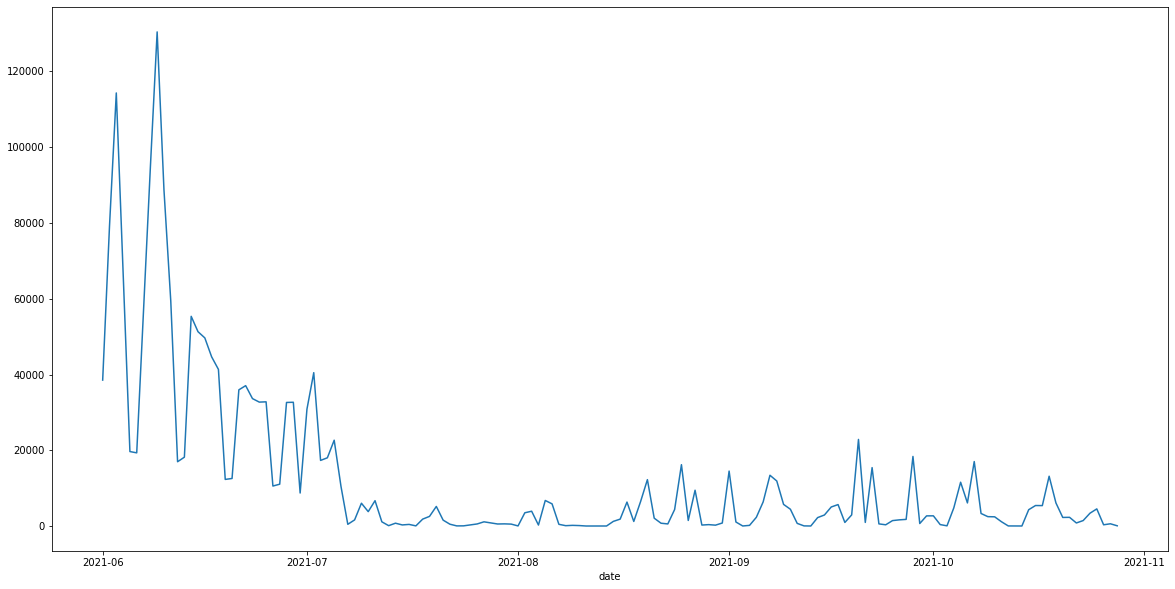

In [14]:
smaller_comments_in_db.groupby(smaller_comments_in_db.date.dt.date)["id"].count().plot(figsize=(20, 10))